In [42]:
import pandas as pd
df1 = pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv")
df1 = df1.set_index('Date')
df1 = df1.iloc[3:]
print(df1)

               Open     High      Low    Close    Volume   Name
Date                                                           
2006-01-06   228.66   235.49   226.85   233.06  17759521  GOOGL
2006-01-09   233.44   236.94   230.70   233.68  12795837  GOOGL
2006-01-10   232.44   235.36   231.25   235.11   9104719  GOOGL
2006-01-11   235.87   237.79   234.82   236.05   9008664  GOOGL
2006-01-12   237.10   237.73   230.98   232.05  10125212  GOOGL
...             ...      ...      ...      ...       ...    ...
2017-12-22  1070.00  1071.72  1067.64  1068.86    889446  GOOGL
2017-12-26  1068.64  1068.86  1058.64  1065.85    918767  GOOGL
2017-12-27  1066.60  1068.27  1058.38  1060.20   1116203  GOOGL
2017-12-28  1062.25  1064.84  1053.38  1055.95    994249  GOOGL
2017-12-29  1055.49  1058.05  1052.70  1053.40   1180340  GOOGL

[3016 rows x 6 columns]


In [43]:
from datasets import load_dataset

In [46]:
from datasets import Dataset, DatasetDict

df1.index = pd.to_datetime(df1.index)

# Resample the data by month and get the values for each month
monthly_data = df1.resample('M').agg(lambda x: x.tolist())

# Calculate the index to split the data into train and validation (80-20 split)
split_index = int(22/2)
split_val = int(22/2 + 22/4)


# Create 'train' and 'validation' dictionaries
train_dataset = {
    'start': monthly_data.index,
    'target': [month[:split_val] for month in monthly_data['Close']],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

validation_dataset = {
    'start': monthly_data.index,
    'target': monthly_data['Close'],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

test_dataset = {
    'start': monthly_data.index,
    'target': monthly_data['Close'],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

# Create Dataset objects
train_dataset = Dataset.from_dict(train_dataset)
test_dataset = Dataset.from_dict(test_dataset)
validation_dataset = Dataset.from_dict(validation_dataset)

# Create the DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

# Display or use the dataset_dict as needed
print(dataset)

/tmp/ipykernel_10924/1120478170.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df1.resample('M').agg(lambda x: x.tolist())


DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 144
    })
    validation: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 144
    })
    test: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 144
    })
})


In [47]:
validation_example = dataset['validation'][0]
train_example = dataset['train'][0]
validation_example.keys()

dict_keys(['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'])

In [48]:
print(validation_example['start'])
print(validation_example['target'])
print(train_example['start'])
print(train_example['target'])

2006-01-31 00:00:00
[233.06, 233.68, 235.11, 236.05, 232.05, 233.36, 233.79, 222.68, 218.44, 199.93, 213.96, 221.74, 216.72, 217.35, 216.96, 213.62, 216.55]
2006-01-31 00:00:00
[233.06, 233.68, 235.11, 236.05, 232.05, 233.36, 233.79, 222.68, 218.44, 199.93, 213.96, 221.74, 216.72, 217.35, 216.96, 213.62]


In [49]:
len(train_example["target"])

16

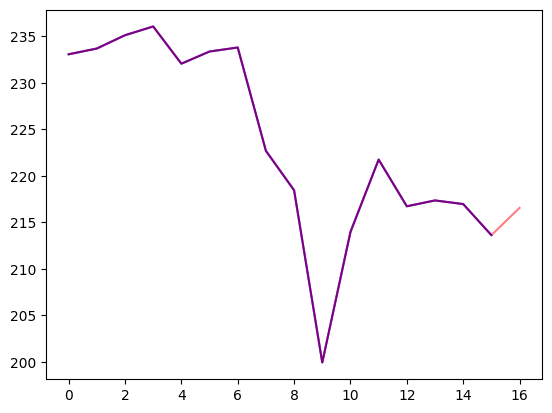

In [50]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()


In [51]:
train_dataset = dataset["train"]
test_dataset = dataset["train"]

In [52]:
from functools import lru_cache

import pandas as pd
import numpy as np


def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [68]:
freq

'1D'

In [53]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [54]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)


[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [55]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_week at 0x7fcec5f261f0>, <function day_of_month at 0x7fcec5f26310>, <function day_of_year at 0x7fcec5f26430>]


In [56]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=0,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=64,
)

model = TimeSeriesTransformerForPrediction(config)

In [57]:
model.config.distribution_output

'student_t'

In [58]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [59]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [60]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [61]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [62]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )



In [63]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=64,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [64]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([64, 1105, 4]) torch.FloatTensor
past_values torch.Size([64, 1105]) torch.FloatTensor
past_observed_mask torch.Size([64, 1105]) torch.FloatTensor
future_time_features torch.Size([64, 6, 4]) torch.FloatTensor
future_values torch.Size([64, 6]) torch.FloatTensor
future_observed_mask torch.Size([64, 6]) torch.FloatTensor


In [65]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [66]:
print("Loss:", outputs.loss.item())

Loss: 7.225795745849609


In [67]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-3)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Ensure the input tensors have the correct data type
        static_categorical_features = (
            batch["static_categorical_features"]
            .to(device)
            .to(torch.float)  # Convert to float if not already
            if config.num_static_categorical_features > 0
            else None
        )

        static_real_features = (
            batch["static_real_features"]
            .to(device)
            .to(torch.float)  # Convert to float if not already
            if config.num_static_real_features > 0
            else None
        )

        past_time_features = batch["past_time_features"].to(device)
        past_values = batch["past_values"].to(device)
        future_time_features = batch["future_time_features"].to(device)
        future_values = batch["future_values"].to(device)
        past_observed_mask = batch["past_observed_mask"].to(device)
        future_observed_mask = batch["future_observed_mask"].to(device)

        outputs = model(
            static_categorical_features=static_categorical_features,
            static_real_features=static_real_features,
            past_time_features=past_time_features,
            past_values=past_values,
            future_time_features=future_time_features,
            future_values=future_values,
            past_observed_mask=past_observed_mask,
            future_observed_mask=future_observed_mask,
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

7.72793436050415
5.941880702972412
5.3252644538879395
5.116443157196045
4.162913799285889
4.113437175750732
5.165891170501709
4.125537395477295
4.545813083648682
3.955360174179077
4.719736576080322
4.7317118644714355
5.0188374519348145
4.94714879989624
4.791019916534424
4.379985332489014
4.529537677764893
4.434020519256592
4.005436420440674
4.219296932220459
4.264805316925049
4.351949214935303
3.8942794799804688
3.9238510131835938
3.992532730102539
3.833709716796875
3.9975783824920654
4.05086612701416
3.969406843185425
4.419233798980713
3.4834606647491455
3.6891958713531494
3.7538881301879883
3.9383394718170166
3.892958641052246
3.6993887424468994
3.8176679611206055
3.8439643383026123
3.3445701599121094


KeyboardInterrupt: 

In [ ]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts[0].shape

In [ ]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

In [ ]:
import matplotlib.dates as mdates


def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=validation_dataset[ts_index][FieldName.START],
        periods=len(validation_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()


    # Major ticks every day
    ax.xaxis.set_major_locator(mdates.DayLocator())
    # Minor ticks every 6 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 6)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

    ax.plot(
        index,
        validation_dataset[ts_index]["target"],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()